In [1]:
import os
import cv2
import numpy as np
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K
from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()
import pickle

Segmentation Models: using `keras` framework.


In [2]:
root_directory = 'E:/ml & dl/archive/archive/Semantic segmentation dataset'

patch_size = 256

In [3]:
image_dataset = []  
for path, subdirs, files in os.walk(root_directory): 
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':   
        images = os.listdir(path)  
        for i, image_name in enumerate(images):  
            if image_name.endswith(".jpg"):   
               
                image = cv2.imread(path+"/"+image_name, 1) 
                SIZE_X = (image.shape[1]//patch_size)*patch_size 
                SIZE_Y = (image.shape[0]//patch_size)*patch_size 
                image = Image.fromarray(image)
                image = image.crop((0 ,0, SIZE_X, SIZE_Y))  
                image = np.array(image)             
       

                print("Now patchifying image:", path+"/"+image_name)
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  
        
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        single_patch_img = patches_img[i,j,:,:]
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        single_patch_img = single_patch_img[0]                            
                        image_dataset.append(single_patch_img)

Now patchifying image: E:/ml & dl/archive/archive/Semantic segmentation dataset\Tile 1\images/image_part_001.jpg
Now patchifying image: E:/ml & dl/archive/archive/Semantic segmentation dataset\Tile 1\images/image_part_002.jpg
Now patchifying image: E:/ml & dl/archive/archive/Semantic segmentation dataset\Tile 1\images/image_part_003.jpg
Now patchifying image: E:/ml & dl/archive/archive/Semantic segmentation dataset\Tile 1\images/image_part_004.jpg
Now patchifying image: E:/ml & dl/archive/archive/Semantic segmentation dataset\Tile 1\images/image_part_005.jpg
Now patchifying image: E:/ml & dl/archive/archive/Semantic segmentation dataset\Tile 1\images/image_part_006.jpg
Now patchifying image: E:/ml & dl/archive/archive/Semantic segmentation dataset\Tile 1\images/image_part_007.jpg
Now patchifying image: E:/ml & dl/archive/archive/Semantic segmentation dataset\Tile 1\images/image_part_008.jpg
Now patchifying image: E:/ml & dl/archive/archive/Semantic segmentation dataset\Tile 1\images/im

In [4]:
mask_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':   
        masks = os.listdir(path)  
        for i, mask_name in enumerate(masks):  
            if mask_name.endswith(".png"):   
               
                mask = cv2.imread(path+"/"+mask_name, 1) 
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size 
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size 
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  
                mask = np.array(mask)             
       

                print("Now patchifying mask:", path+"/"+mask_name)
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)  
        
                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):
                        
                        single_patch_mask = patches_mask[i,j,:,:]
                        single_patch_mask = single_patch_mask[0]                               
                        mask_dataset.append(single_patch_mask) 

Now patchifying mask: E:/ml & dl/archive/archive/Semantic segmentation dataset\Tile 1\masks/image_part_001.png
Now patchifying mask: E:/ml & dl/archive/archive/Semantic segmentation dataset\Tile 1\masks/image_part_002.png
Now patchifying mask: E:/ml & dl/archive/archive/Semantic segmentation dataset\Tile 1\masks/image_part_003.png
Now patchifying mask: E:/ml & dl/archive/archive/Semantic segmentation dataset\Tile 1\masks/image_part_004.png
Now patchifying mask: E:/ml & dl/archive/archive/Semantic segmentation dataset\Tile 1\masks/image_part_005.png
Now patchifying mask: E:/ml & dl/archive/archive/Semantic segmentation dataset\Tile 1\masks/image_part_006.png
Now patchifying mask: E:/ml & dl/archive/archive/Semantic segmentation dataset\Tile 1\masks/image_part_007.png
Now patchifying mask: E:/ml & dl/archive/archive/Semantic segmentation dataset\Tile 1\masks/image_part_008.png
Now patchifying mask: E:/ml & dl/archive/archive/Semantic segmentation dataset\Tile 1\masks/image_part_009.png
N

In [5]:
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)

In [6]:
# import pickle

# pickle_out = open("image_dataset.pickle","wb")
# pickle.dump(image_dataset, pickle_out)
# pickle_out.close()


# pickle_out = open("mask_dataset.pickle","wb")
# pickle.dump(mask_dataset, pickle_out)
# pickle_out.close()

In [7]:
# pickle_in = open("image_dataset.pickle","rb")
# image_dataset = pickle.load(pickle_in)



# pickle_in = open("mask_dataset.pickle","rb")
# labels_cat = pickle.load(pickle_in)

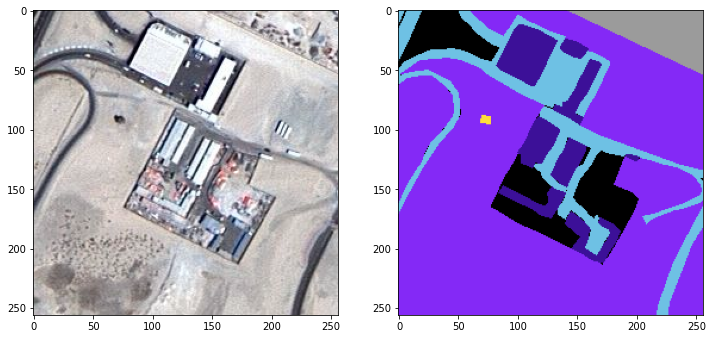

In [68]:
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()

In [9]:

Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

Road = '#6EC1E4'.lstrip('#') 
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

Vegetation =  '#FEDD3A'.lstrip('#') 
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

Water = '#E2A929'.lstrip('#') 
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

Unlabeled = '#9B9B9B'.lstrip('#') 
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155


60


In [10]:
def rgb_to_2D_label(label):
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == Building,axis=-1)] = 0
    label_seg [np.all(label==Land,axis=-1)] = 1
    label_seg [np.all(label==Road,axis=-1)] = 2
    label_seg [np.all(label==Vegetation,axis=-1)] = 3
    label_seg [np.all(label==Water,axis=-1)] = 4
    label_seg [np.all(label==Unlabeled,axis=-1)] = 5
    
    label_seg = label_seg[:,:,0]  
    
    return label_seg

In [11]:
labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)    

labels = np.array(labels)   
labels = np.expand_dims(labels, axis=3)

print("Unique labels in label dataset are: ", np.unique(labels))

Unique labels in label dataset are:  [0 1 2 3 4 5]


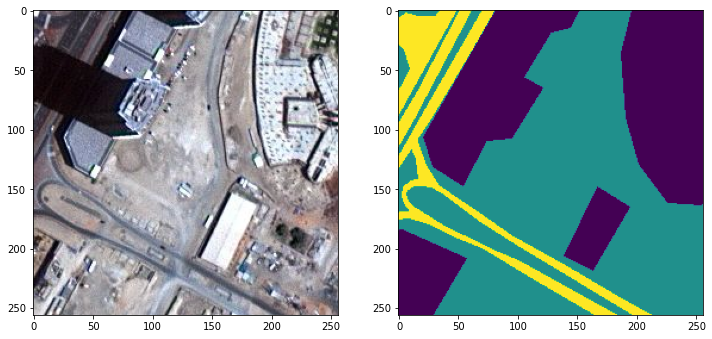

In [12]:
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()

In [13]:

n_classes = len(np.unique(labels))

labels_cat = tf.keras.utils.to_categorical(labels, num_classes=n_classes)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)


In [14]:

weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights=weights) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)  

In [15]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

In [16]:
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

def multi_unet_model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):

    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2) 
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)  # Original 0.1
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

In [17]:
metrics=['accuracy', jacard_coef]

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer='adam', loss=total_loss, metrics=metrics)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        dropout[0][0]                    
______________________________________________________________________________________________

In [18]:
history1 = model.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=50, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

Epoch 1/50
66/66 [==============================] - 502s 8s/step - loss: 0.9919 - accuracy: 0.5786 - jacard_coef: 0.2909 - val_loss: 0.9705 - val_accuracy: 0.6911 - val_jacard_coef: 0.3968
Epoch 2/50
66/66 [==============================] - 488s 7s/step - loss: 0.9628 - accuracy: 0.6943 - jacard_coef: 0.4314 - val_loss: 0.9517 - val_accuracy: 0.7463 - val_jacard_coef: 0.4718
Epoch 3/50
66/66 [==============================] - 487s 7s/step - loss: 0.9505 - accuracy: 0.7390 - jacard_coef: 0.4912 - val_loss: 0.9444 - val_accuracy: 0.7566 - val_jacard_coef: 0.5189
Epoch 4/50
66/66 [==============================] - 488s 7s/step - loss: 0.9390 - accuracy: 0.7739 - jacard_coef: 0.5497 - val_loss: 0.9468 - val_accuracy: 0.7537 - val_jacard_coef: 0.5412
Epoch 5/50
66/66 [==============================] - 486s 7s/step - loss: 0.9344 - accuracy: 0.7886 - jacard_coef: 0.5699 - val_loss: 0.9395 - val_accuracy: 0.7734 - val_jacard_coef: 0.5625
Epoch 6/50
66/66 [==============================] - 480

In [19]:
model.save('aerial_satellite0.hdf5')

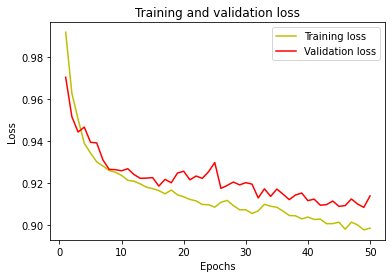

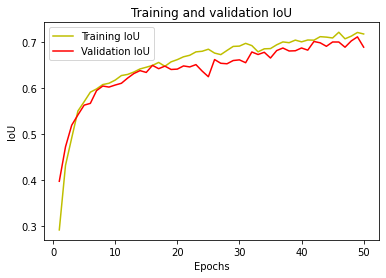

In [20]:
history = history1
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [21]:
# from keras.models import load_model
# model = load_model("aerial_satellite0.hdf5",
#                    custom_objects={'dice_loss_plus_1focal_loss':total_loss,
#                                    'jacard_coef':jacard_coef})

In [48]:
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

from keras.metrics import MeanIoU
n_classes = 6
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.56283265


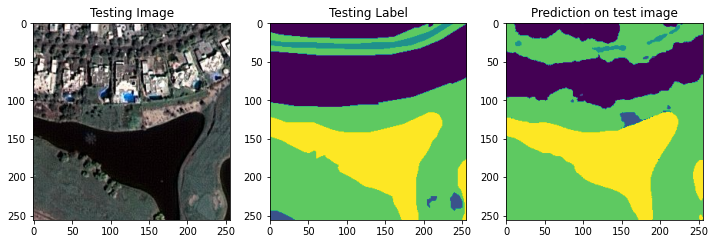

In [71]:
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()
